In [60]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
plt = mpl.pyplot
#from matplotlib import pyplot as plt
import seaborn as sns
from collections import namedtuple as nt
from collections import defaultdict as ddict
from collections import OrderedDict as odict
from copy import deepcopy
import pickle

import sys
sys.path.append("./../") # adds parent directory to path
import stationary_distribution_aug as sd
import mutator_classes as mc

In [61]:
# set plotting parameters
sns.set_style('whitegrid')

mpl.rcParams['figure.dpi'] = 400
font_size = 10
mpl.rcParams['axes.titlesize'] = font_size
mpl.rcParams['axes.labelsize'] = font_size
mpl.rcParams['xtick.labelsize'] = font_size
mpl.rcParams['ytick.labelsize'] = font_size
mpl.rcParams['legend.fontsize'] = font_size
mpl.rcParams['legend.title_fontsize'] = font_size

purple = [0.7,0.1,0.7]
coral = [.973, .414, .575]
teal = [0,0.55,0.55]
charcoal = [0.3,0.3,0.3]

def common_axes_modifications(ax,
                              title = '',
                              xlabel = '',
                              ylabel=''):

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title,pad=10)
    
    plt.sca(ax)
    plt.tick_params(bottom=True, top=False, left=True, right=False,which='both')
    plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
   
        
    ax.spines['bottom'].set_color('k')
    ax.spines['top'].set_color('k')
    ax.spines['left'].set_color('k')
    ax.spines['right'].set_color('k')
    
    ax.grid(color=[0.9,0.9,0.9,0])

In [62]:
# calculate phi
def get_phi(s,p):
    phi = s/(4*p.N*p.h*p.s*p.loci)
    return phi

# define an easy to use object for keeping rack of results
class Result_object:
    
    def __init__(self,S,frequency_mean,between_variance,within_variance,seg_variance,phi,params,statdist):
        self.S = S
        self.frequency_mean = frequency_mean
        self.between_variance = between_variance
        self.within_variance = within_variance
        self.seg_variance = seg_variance
        self.phi = phi
        self.params = params
        self.statdist = statdist
    
# function to calculate stationary distribution and expected moments of mutator frequency and mutation rates
def process_exp(p,S,rdict):
    
    p.phi = get_phi(S,p) 
    statdist = sd.get_SD(p)
    
    frequency_mean      = sum(i*p for i,p in statdist.items())
    between_variance  = sum(i**2*p for i,p in statdist.items()) - frequency_mean**2
    seg_variance        = sum((i-frequency_mean)**2*p for i,p in statdist.items() if i > 0 and i < 1)
    within_variance     = sum(2*i*(1-i)*p for i,p in statdist.items())
    
    x = Result_object(S = S,
                     frequency_mean = frequency_mean,
                     between_variance = between_variance,
                     within_variance = within_variance,
                     seg_variance = seg_variance,
                     phi = p.phi,
                     params = params,
                     statdist = statdist)
    rdict[S] = x

In [63]:
# calculate expected results
params = mc.Parameters(**{'mutation_rate':1,'h':1,'s':0.0005,'mutator_mutation_rate':1.25e-8,'M':1,'phi':1,'N':20000,'loci':3e9*0.08})
        
exp_results = odict()
for S in np.logspace(-2,3,100):
    process_exp(p = params,S = S,rdict = exp_results)

In [64]:
# function to determine Mphi 
mean_mutation_rate = 1.25e-8
def nvals(mean_freq,mean_mutation_rate,phi,phi_adjust = 1):
    return mean_mutation_rate/(2*phi*phi_adjust*mean_freq)


1.0 2.695652173913044 2.695525


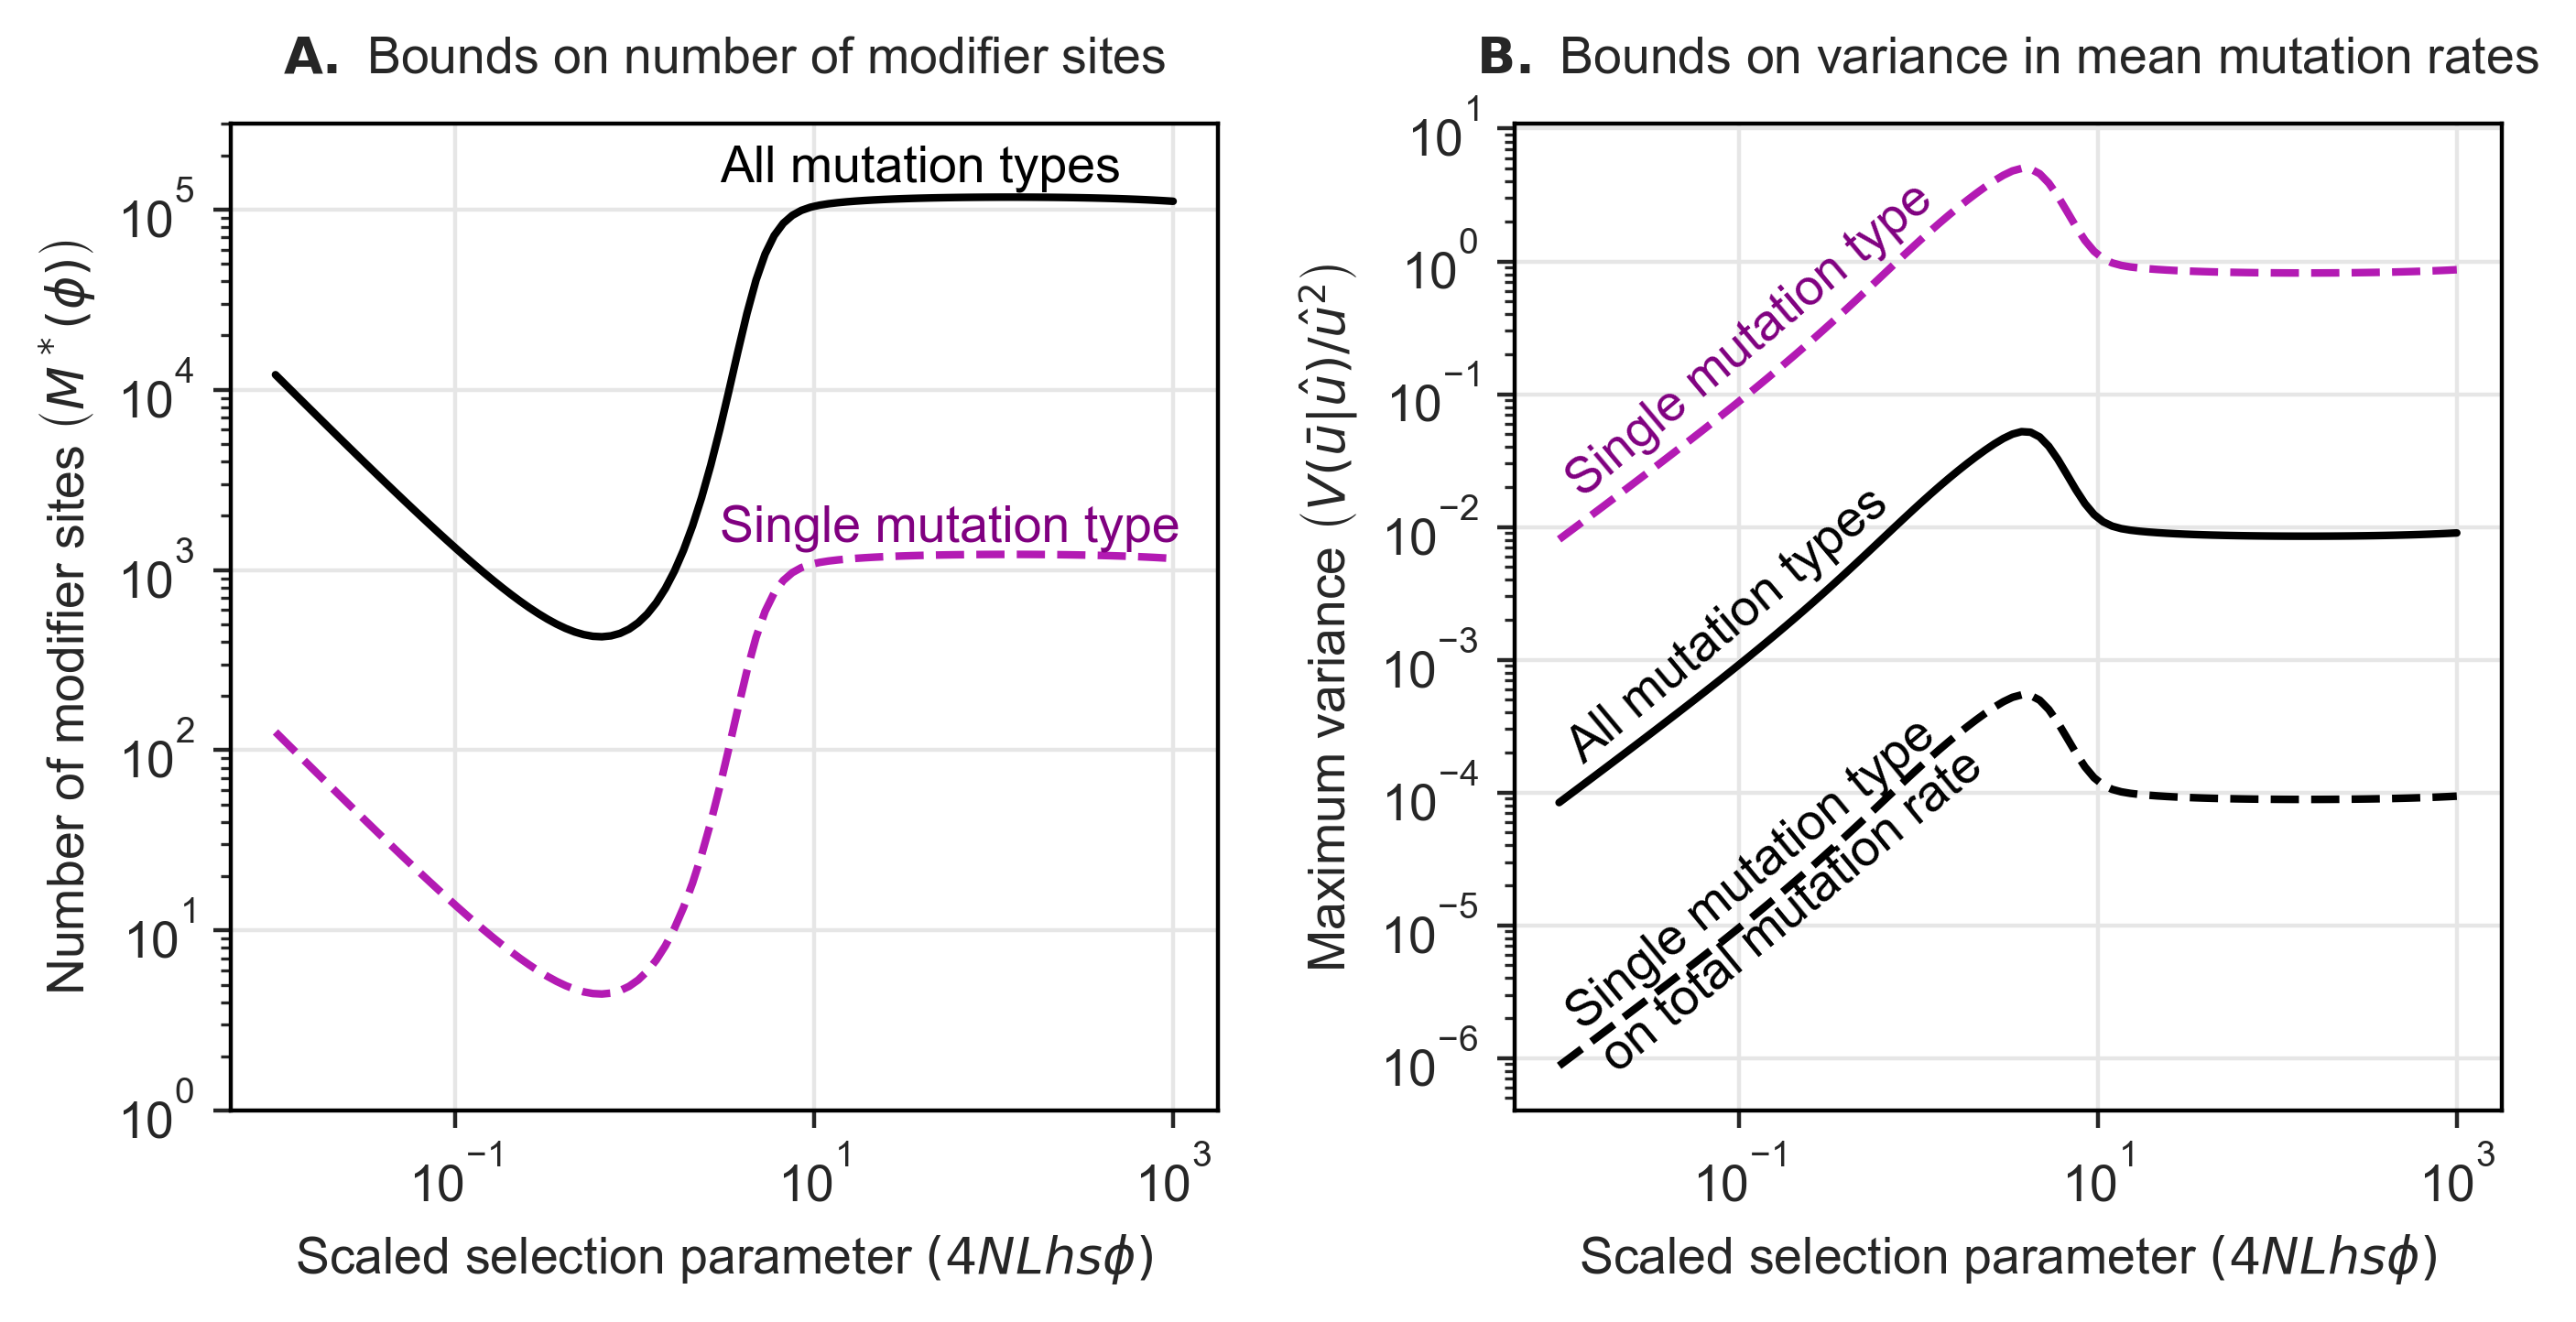

In [68]:
fig, (ax1,ax2) = plt.subplots(figsize=(8,3.6925),nrows=1,ncols=2)

# we want to consider what happens when mutations affect the whole genome or just one type
# to that end, we keep S constant. So mutators that affect only a single mutation affect 1/32x fewer sites so have a phi that is 32x higher
# they also have 1/3 the expected mutation rate
for phi_adjust,mutation_rate_adjust,ls,color in zip([1,32],[1,3],['-','--'],['k',purple]):
    
    
    x = [i.S for i in exp_results.values()]
    
    # calcuate maximum M
    maxM = nvals(mean_freq = np.array([i.frequency_mean for i in exp_results.values()]),
                 mean_mutation_rate = mean_mutation_rate/mutation_rate_adjust,
                 phi = np.array([i.phi for i in exp_results.values()]),
                 phi_adjust = phi_adjust)
    
    # calcualte expected variance
    variance = np.array([i.between_variance*(2*i.phi*phi_adjust)**2 for i in exp_results.values()])
    
    # plot max M
    ax1.plot(x,
             maxM,
             color = color,
             ls = ls)
    
    # calculate and plot maximum between population variance relative to mutation type's expected rate
    ax2.plot(x,
             variance*maxM/(mean_mutation_rate/mutation_rate_adjust)**2,
             color=color,
             ls = ls)
    
    # calculate and plot maximum between population variance relative to total expected rate
    if phi_adjust == 32:
        
        ax2.plot(x,
                 variance*maxM/(mean_mutation_rate)**2/(phi_adjust)**2,
                 color='k',
                 ls = '--')

# add text and make graph nice
ax1.text(x = 3, y = 1.1e5*1.3, s = 'All mutation types',color='k',size=10)
ax1.text(x = 3, y = 1.1e3*1.3, s = 'Single mutation type',color='purple',size=10)
ax1.set_ylim([1,3e5])

ax2.text(x = 1e-2, y = 1.7e-2, s = 'Single mutation type',color='purple',rotation = 40,size=10)
ax2.text(x = 1e-2, y = 1.7e-4, s = 'All mutation types',color='k',rotation = 40,size=10)
ax2.text(x = 1e-2, y = 0.8e-6, s = 'Single mutation type\non total mutation rate',color='k',rotation = 39.5,size=10)


common_axes_modifications(ax = ax1,
                          title = r'$\bf{A.}$ Bounds on number of modifier sites',
                          ylabel = 'Number of modifier sites ' + r'$\left(M^*(\phi)\right)$',
                          xlabel = 'Scaled selection parameter ' + r'$\left(4NLhs\phi\right)$')

common_axes_modifications(ax = ax2,
                          title = r'$\bf{B.}$ Bounds on variance in mean mutation rates',
                          ylabel = 'Maximum variance ' + r'$\left( V(\bar{u}|\hat{u})/ \hat{u}^2\right)$',
                          xlabel = 'Scaled selection parameter ' + r'$\left(4NLhs\phi\right)$')
plt.subplots_adjust(wspace=0.3,bottom = 0.15)
bbox = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height
print(round(width/height,3),width,height)
plt.savefig('/Users/will_milligan/Desktop/MutatorFigures/Fig2.pdf',dpi=400,bbox_inches='tight')

1.0 3.1 3.09885


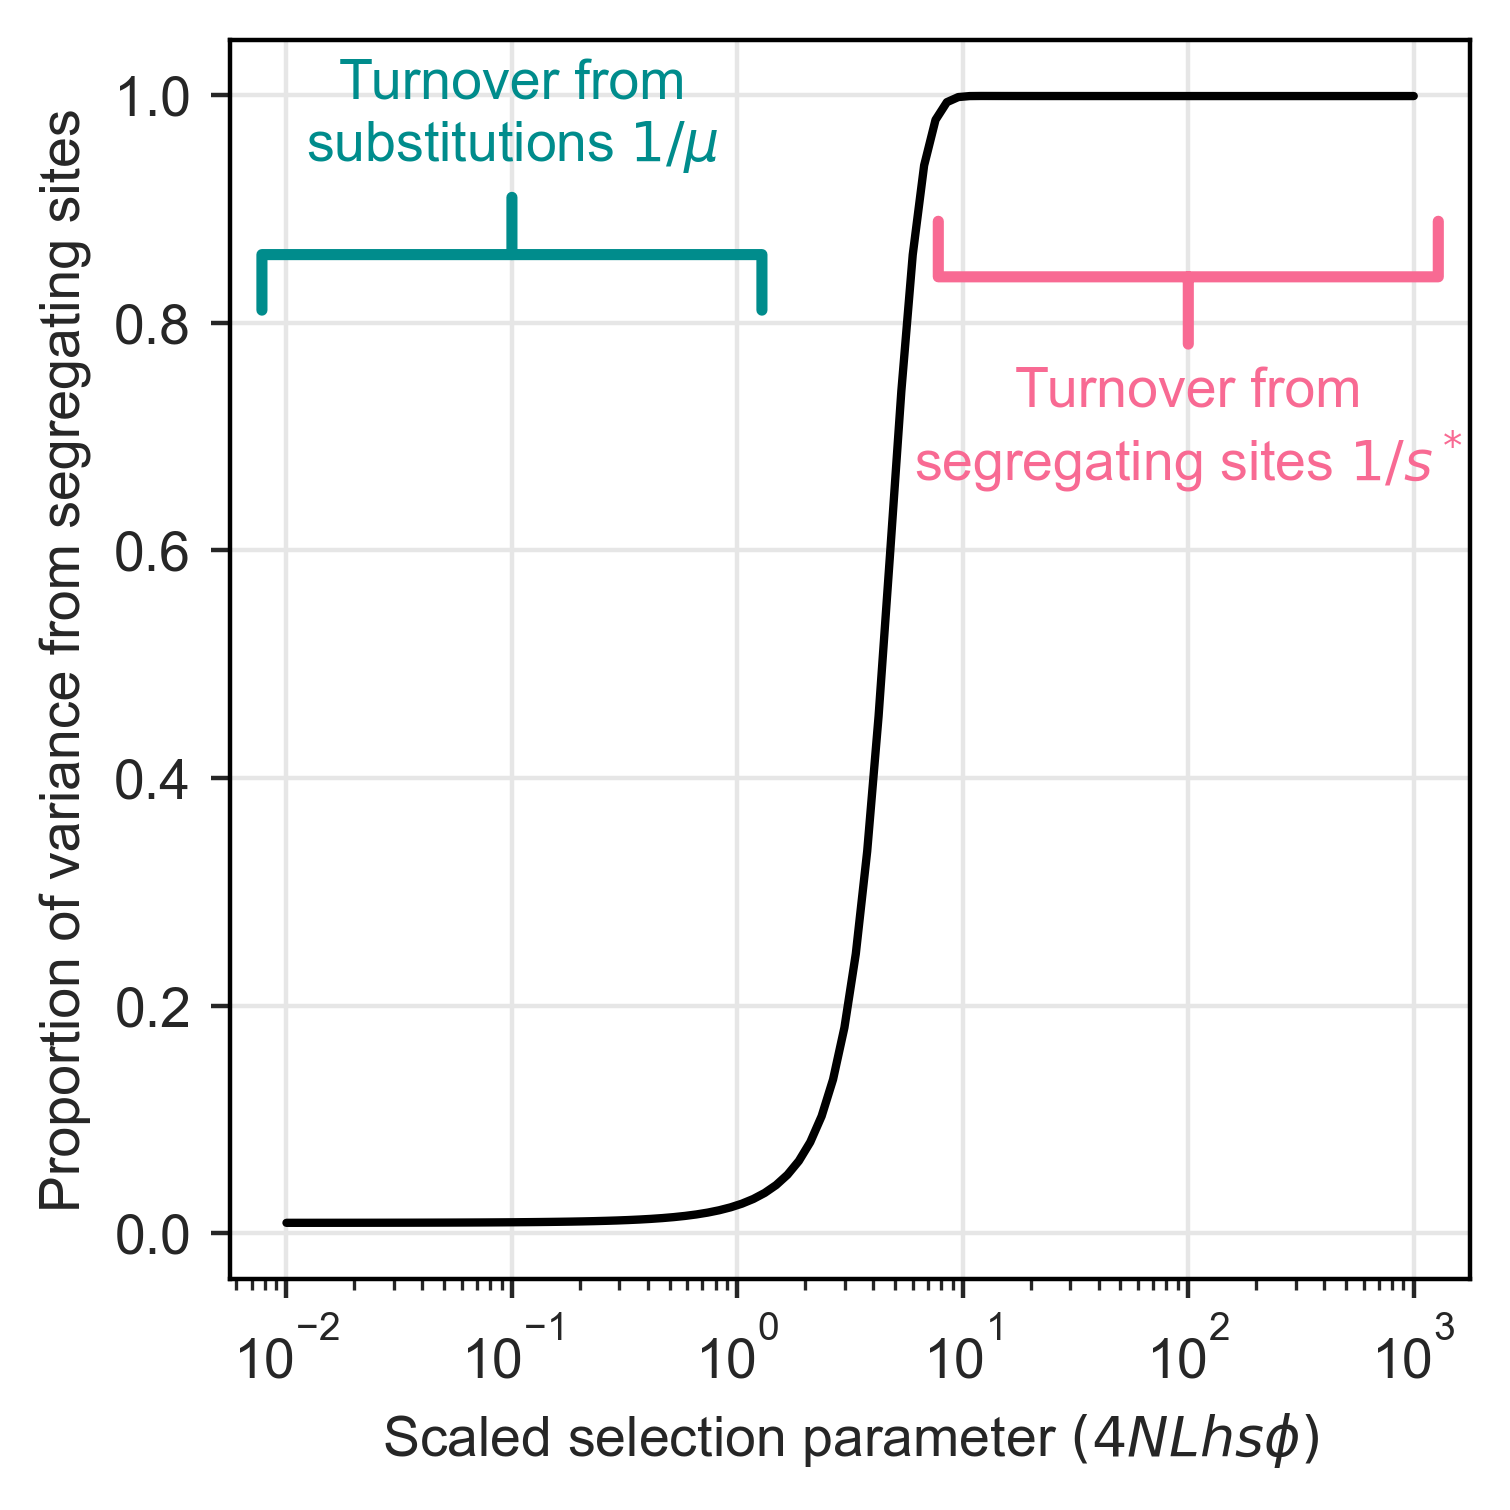

In [66]:
#figure S7

fig, ax1 = plt.subplots(figsize=(4,4.245),nrows=1,ncols=1)

# calculate and plot proportion of variance that comes from segregating sites
x = [i.S for i in exp_results.values()]
y = [i.seg_variance/i.between_variance for i in exp_results.values()]
ax1.plot(x,y,color='k')

# make graph nice
common_axes_modifications(ax1,
                          xlabel = 'Scaled selection parameter ' + r'$\left(4NLhs\phi\right)$',
                          ylabel = 'Proportion of variance from segregating sites',
                          title ='')
plt.yscale('linear')

# add text and brackets
ax1.annotate('Turnover from\nsubstitutions ' + r'$1 / \mu$', 
             xy=(0.1, 0.85), 
             xytext=(0.1, 0.93),  
             fontsize=10, 
             ha='center', 
             va='bottom',
             arrowprops=dict(arrowstyle='-[, widthB=4.5, lengthB=1',
                             lw=2.0,color=teal),
             color = teal)

ax1.annotate('Turnover from\nsegregating sites ' + r'$1 / s^*$', 
             xy=(100, 0.85), 
             xytext=(100, 0.65),  
             fontsize=10, 
             ha='center', 
             va='bottom',
             arrowprops=dict(arrowstyle='-[, widthB=4.5, lengthB=1',
                             lw=2.0,color=coral),
             color = coral)

plt.subplots_adjust(bottom = 0.15)
bbox = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height
print(round(width/height,3),width,height)